<a href="https://colab.research.google.com/github/ToM4tto/MovieCompanion/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSD3185 Group 26 Machine Learning Project**: 
## MovieCompanion - A Movie Recommendation System

## Mounting Google Drive

In [156]:
#Load the Drive helper and mount
from google.colab import drive

#This will prompt for authorisation
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data
**The Movies Dataset** - Metadata on over 45,000 movies. 26 million ratings from over 270,000 users: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

The following files from the dataset were used:
- credits.csv
- keywords.csv
- links_small.csv
- movies_metadata.csv
- ratings_small.csv

Make sure you have the datasets in a folder "data" within your Google Drive when running this project



In [157]:
import pandas as pd 
import numpy as np
from ast import literal_eval 

df1 = pd.read_csv("/content/drive/MyDrive/data/movies_metadata.csv", low_memory=False)
df2 = pd.read_csv("/content/drive/MyDrive/data/credits.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data/keywords.csv")
links_small = pd.read_csv("/content/drive/MyDrive/data/links_small.csv")

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

##### CLEAN DATA #####
#df1['genres'] = df1['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Apply the convert_int function to the 'id' column in df1
df1['id'] = df1['id'].apply(convert_int) #some id cannot be converted to int, data elements should be removed

# Drop rows with NaN values in the 'id' column
df1.dropna(subset=['id'], inplace=True)

# Convert all ids to int
df1['id'] = df1['id'].astype('int')
df2['id'] = df2['id'].astype('int')
df3['id'] = df3['id'].astype('int')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# Merge the two DataFrames on the 'id' column
df1 = df1.merge(df2,on='id')
df1 = df1.merge(df3,on='id')

df1 = df1[df1['id'].isin(links_small)] # REDUCE 45K DATASET TO 9K (not enough resources in free Colab environment)
df1 = df1.reset_index()
#Peek our data
df1.head(3)

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


## Visualising Data (optional)

In [158]:
import matplotlib.pyplot as plt

#enable graph render inline on Jupyter notebooks
%matplotlib inline 

#Make smaller dataframe with lesser cols
ratings = df1[["title", "vote_average", "vote_count"]]

# Sort the DataFrame by highest vote_score given the highest vote_count
ratings = ratings.sort_values(['vote_count', 'vote_average'], ascending=[False, False])

#Peek at our data
ratings.head(5)

,title,vote_average,vote_count
7648,Inception,8.1,14075.0
6981,The Dark Knight,8.3,12269.0
7488,Avatar,7.2,12114.0
7969,The Avengers,7.4,12000.0
8871,Deadpool,7.4,11444.0


Distribution of Vote_Count (frequency vs vote_count)


<Axes: >

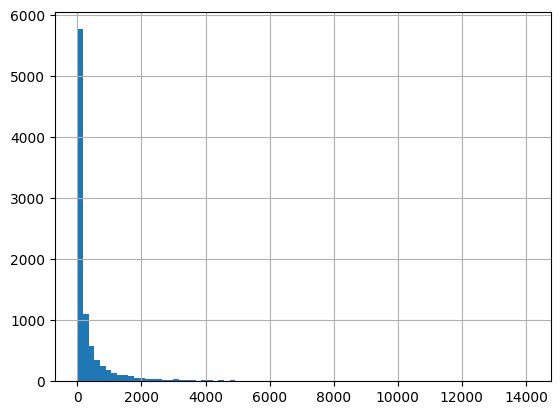

In [159]:
#Print Distribution of vote_count
print("Distribution of Vote_Count (frequency vs vote_count)")
ratings['vote_count'].hist(bins=80)

Distribution of Average Vote (frequency vs vote_average)


<Axes: >

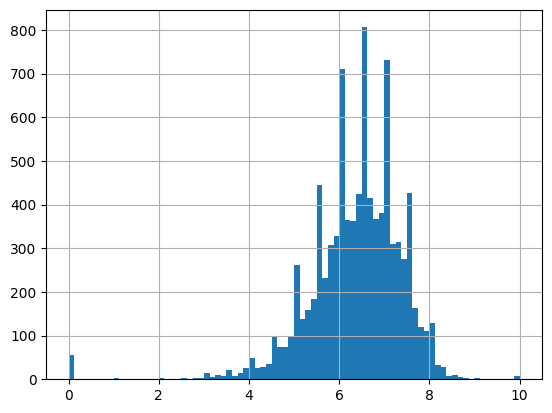

In [160]:
#Print Distribution of Average Votes
print("Distribution of Average Vote (frequency vs vote_average)")
ratings['vote_average'].hist(bins=80)

## **Algorithm 1:** Content-based Filtering

We will be computing scores for all movies based on different features (Overview, Credits, Genres and Keywords) in order to make good recommendations.

We need to compute the **Term Frequency-Inverse Document Frequency (TF-IDF) vectors**  for each plot overview. The TF-IDF score for a given word in a given document is high if that word appears frequently in that document but infrequently in the other documents. Conversely, the score is low if the word appears frequently in many documents in the corpus. By calculating the TF-IDF score for each word in each document, we can identify the words that are most strongly associated with each document, which can be useful for tasks such as document classification or information retrieval.

We will obtain a **TF-IDF matrix**  where each column represents a word in the combined set of movie overviews and each row represents a movie. Each element would represent the TFIDF score of the word in col for the movie in row. This allows us to filter significant words and therefore their significance to the various movies, helping us in our recommendation.

**Getting plot overview**

In [161]:
#Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each plot overview
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove common english stop words e.g: "the", "a"
tfidf = TfidfVectorizer(stop_words = "english")

#Clean Data by removing NaN empty string
df1["overview"] = df1["overview"].fillna("")

#Construct TF-IDF matrix by fitting and transforming the data (text) into a TF-IDF matrix representation
tfidf_matrix = tfidf.fit_transform(df1["overview"])

#Output the shape of tfidf_matrix
# 20978 different words describe 4803 movies in our data
tfidf_matrix.shape

(9219, 29727)

Calculate the Cosine Similarity: 

In [162]:
#Import linear_kernel (dot product)
from sklearn.metrics.pairwise import cosine_similarity

#Cosine similarity is the dot product between two normalized vectors, the similarity between all pairs of movies in the dataset
#each element (i,j) in the cosine_sim matrix represents the dot product of the ith row of tfidf with the jth row of tfidf,
#this calculates similarity with every other movie (row)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#Create a mapping between movie titles and their indices in the dataset, dropping duplicate movie titles
title_to_indices = pd.Series(df1.index, df1['title']).drop_duplicates()
title_to_indices.shape

(9219,)

**Simple search engine**

In [163]:
import nltk
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import linear_kernel

searchDF = df1.copy()

# Convert all text to lowercase
searchDF['title'] = searchDF['title'].str.lower()

# Remove stop words (common words such as "the", "and", "a")
nltk.download('stopwords')
stop_words = stopwords.words('english')
searchDF['title'] = searchDF['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Stem the words (reduce each word to its root form)
# stemmer = SnowballStemmer('english')
# searchDF['title'] = searchDF['title'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()])) 

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(searchDF['title'])

search_cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Create a mapping between movie titles and their indices in the dataset, dropping duplicate movie titles
title_to_indices_search = pd.Series(searchDF.index, searchDF['title']).drop_duplicates()

def get_similar_titles(title, cosine_similarities, df):
    title = title.lower()
    if (title not in title_to_indices_search.index):
      print("No movie with similar title")
      return
    # Get the index of the given title
    idx = title_to_indices_search[title]

    # Get the cosine similarities of the given title with all other titles
    sim_scores = list(enumerate(cosine_similarities[idx]))

    # Sort the similarities in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 most similar titles (excluding the given title)
    sim_scores = sim_scores[1:11]
    title_indices = [i[0] for i in sim_scores]
    return df1['title'].iloc[title_indices]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Content-based Recommender function**

In [164]:
# Function that takes in movie title as input and outputs most similar movies
def getRecommendations(title, cosine_sim, top=10):
    # Error checking, invalid movie title
    if (title not in title_to_indices.index):
      print("Exact movie not found, searching for similar titles:")
      print(get_similar_titles(title, search_cosine_sim, df1))
      return
    # Index of the movie that has the title
    index = title_to_indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = cosine_sim[index]

    # Sort movies based on the similarity scores in desc order and return top 10 most similar
    # Gets the array of indices if it were to be sorted
    movie_indices = np.argsort(-sim_scores)[1:top+1]

    # Return the top 10 most similar movies, gets location from df1
    return pd.DataFrame({'movieId': movie_indices, 'title': df1.loc[movie_indices, 'title'].tolist()})


In [165]:
getRecommendations('Iron Man', cosine_sim, 10) #using just plot overview (we're not done yet, see below)

,movieId,title
0,7600,Iron Man 2
1,8392,Iron Man 3
2,5730,Scarface
3,8868,Avengers: Age of Ultron
4,8190,Brake
5,6129,Hostage
6,2340,The Dark Half
7,4316,Saturday Night Fever
8,6218,Batman Begins
9,1019,Touch of Evil


**This code changes dataframe, run this code once!**

In [166]:
# Parse the stringified features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df1[feature] = df1[feature].apply(literal_eval)

# Get Director from "crew" feature lists
def getDirector(crews):
    for crew in crews:
        #if isinstance(crew, dict):
          if crew['job'] == 'Director':
            return crew['name']
    return np.nan

# Returns Top 3 in "cast", "keywords", "genres" feature lists

def getTop3(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if > 3 elements. If no, returns entire list. 
        if len(names) >= 3:
            names = names[:3]
        return names
    #Return empty list in case of missing/malformed data
    return []

features = ['cast', 'keywords', 'genres']
for feature in features:
    df1[feature] = df1[feature].apply(getTop3) # Apply function along an axis of the DataFrame, each object passed to function should be a Series list

# Set director, cast, genres and keywords features in a suitable format.
df1['director'] = df1['crew'].apply(getDirector)

# Print the new features of the first 3 films
df1.head(3)

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",John Lasseter
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",Joe Johnston
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger]",Howard Deutch


In [167]:
#Clean Data by converting ALL strings to lowercase and remove spaces
def clean_data(x):
    if isinstance(x, list):
      return [str.lower(i.replace(" ", "")) for i in x]
    else:
      #Check if Director exists. If not, return empty string
      if isinstance(x, str):
        return str.lower(x.replace(" ", ""))
      else:
        return ""

features = ['cast', 'keywords', 'director', 'genres']
# Apply clean_data function to your features
for feature in features:
  df1[feature] = df1[feature].apply(clean_data)

def collectiveSoup(x):
    return " ".join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df1['soup'] = df1.apply(collectiveSoup, axis=1) #combine the top 3 in 1 string in a new dataframe

CountVectorizer() instead of TF-IDF as we do not want to reduce the significance of an actor/director if they appeared in more movies (TF-IDF would reduce), we just want count of each word in `soup`.
**Changing dataframe, run this code once!**

In [168]:
# Import CountVectorizer and create the count matrix for each unique word in soup
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df1['soup']) #matrix has 1 row per movie and 1 column per unique word in the soup, each element would be the frequency each unique word appeared in soup

#Cosine similarity is the dot product between two normalized vectors (normalised automatically), the similarity between all pairs of movies in the dataset
#each element (i,j) in the cosine_sim2 matrix represents the dot product of the ith row of count_matrix with the jth row of count_matrix,
#this calculates similarity with every other movie (row)
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Combined 'PLOT OVERVIEW' WITH 'cast', 'keywords', 'director', 'genres' similarities
# Normalize the matrices
normalized_cosine_sim1 = cosine_sim / cosine_sim.max()
normalized_cosine_sim2 = cosine_sim2 / cosine_sim2.max()

# Combine the similarity matrices using a weighted sum
alpha = 0.5  # weight for tf-idf matrix
beta = 0.5  # weight for count matrix
combined_sim = alpha * normalized_cosine_sim1 + beta * normalized_cosine_sim2

# Reset index and re-create mapping between movie titles and their indices in the dataset, dropping duplicates was already done
df1 = df1.reset_index()
indices = pd.Series(df1.index, index=df1['title'])

In [169]:
print(get_similar_titles("iron man", search_cosine_sim, df1)) #get similar movie titles
getRecommendations("Iron Man", combined_sim, 15) #get top 15 movies

7600                  Iron Man 2
8392                  Iron Man 3
3613        Tetsuo: The Iron Man
4124                   Iron Will
6045                      3-Iron
781                 The Thin Man
985                The Third Man
3831    The Man Who Wasn't There
5203                 Man on Fire
5302            Another Thin Man
Name: title, dtype: object


,movieId,title
0,7600,Iron Man 2
1,8392,Iron Man 3
2,8868,Avengers: Age of Ultron
3,7764,TRON: Legacy
4,8872,Captain America: Civil War
5,1682,Tron
6,7969,The Avengers
7,2594,Against All Odds
8,232,Star Wars
9,8869,Ant-Man


## **Algorithm 2:** Collaborative Filtering

Currently, our recommender is only able to recommend movies which are close to a certain movie. Different users keying in the same movie will get the exact same recommendations. Now, we want to make it more personal and account for the personal tastes and biases of a user.

We will be using item-item (item-based) collaborative filtering instead of user-user (user-based) as items are simpler than users (more fundamental) and also users' preferences can change over time.

Instead of measuring the similarity (Pearson Correlation or Cosine Similarity)between users, the item-item CF recommends items based on their similarity with other items that the target user rated (we will fill the users vs movies table vertically).

Some issues with item-item method:
1. Scalability - Computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items.
2. Sparsity - In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have a similar rating for the only user who ranked them both.

To minimise this we chose to turn it into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. By using Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

SVD decreases the dimension of a complex matrix by extracting its latent factors/features. Essentially, we map each user and each item into a latent space with dimension r. We will use Surprise library to implement the SVD.

In [170]:
!pip install scikit-surprise
# !conda install -y -c conda-forge scikit-surprise # If you use conda on a non-Colab environment
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv("/content/drive/MyDrive/data/ratings_small.csv")
ratings.head()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Define the SVD algorithm
svd = SVD()

# Use cross_validate to evaluate the performance of the algorithm using 5-fold cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

# Print the results
print("Evaluating RMSE, MAE of algorithm SVD.\n")
for fold_idx, rmse, mae in zip(range(1, 6), results['test_rmse'], results['test_mae']):
    print(f"Fold {fold_idx}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print("------------")
print("------------")
print(f"Mean RMSE: {results['test_rmse'].mean():.4f}") #Should be about 0.89 which is good enough for us
print(f"Mean MAE : {results['test_mae'].mean():.4f}")
print("------------")

trainset = data.build_full_trainset()
svd.fit(trainset)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Evaluating RMSE, MAE of algorithm SVD.

Fold 1
RMSE: 0.8982
MAE:  0.6889
------------
Fold 2
RMSE: 0.8971
MAE:  0.6928
------------
Fold 3
RMSE: 0.8971
MAE:  0.6925
------------
Fold 4
RMSE: 0.8909
MAE:  0.6866
------------
Fold 5
RMSE: 0.9012
MAE:  0.6905
------------
------------
Mean RMSE: 0.8969
Mean MAE : 0.6902
------------


In [171]:
ratings[ratings['userId'] == 1] #Ratings userId 1 has given

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [172]:
estimate = svd.predict(1, 302, 5).est #For user ID = 1, movie ID = 302, we get an estimated prediction of 2.68

# Print the estimate and movie name
print(f"Estimated rating for Movie Id: 302: {estimate}")

Estimated rating for Movie Id: 302: 2.5878373935071224


In [173]:
id_map = pd.read_csv("/content/drive/MyDrive/data/links_small.csv")[['movieId', 'tmdbId']]
# Replace missing or infinite values with -1
id_map['tmdbId'] = id_map['tmdbId'].fillna(-1)
# convert tmdbId column to int
id_map['tmdbId'] = id_map['tmdbId'].astype(int)

# Merge the datasets based on tmdbId in id_map and id in id_map
merged_dataset = pd.merge(id_map, df1, left_on='tmdbId', right_on='id')

# Filter out rows with null values in the budget column
filtered_df = merged_dataset[merged_dataset['title'].notnull()]
#filtered_df.shape

#estimate = svd.predict(1, 10, 3).est #For movie with ID 302, we get an estimated prediction of 2.618

# Pick a user profile between 1 and 671, pick a movie to get predicted rating for
def collaborative_predictor(title, userID = 1):
  if (userID < 1 or userID > 671):
    print("Please select a user group between 1 and 671")
    return
  if title not in filtered_df["title"].values:
    print("Movie not even in dataset, cannot predict rating")
    return
  movieId = filtered_df[filtered_df['title'] == title]['movieId'].values[0]
  estimate = svd.predict(userID, movieId, 3).est
  print(f"User Group {userID}'s Estimated rating for {title} is : {estimate}")

# Pick a user profile between 1 and 671 and see the top rated movies rated by that user group
def listTopMoviesRatedByUser(userID = 1, top = 5):
    if (userID < 1 or userID > 671):
      print("Please select a user group between 1 and 671")
      return
    print(f"Top movies previously rated by User Group {userID}: ")
    user_ratings = ratings[ratings['userId'] == userID] #Ratings of movies in user groups
    sorted_ratings = user_ratings.sort_values(by='rating', ascending=False)
    top_ratings = sorted_ratings.head(top)
     # Join with df1 to get the corresponding movie titles
    top_movies = pd.merge(top_ratings, filtered_df[['title', 'movieId']], on='movieId', how='left')
    # Print out only the rating and title
    return top_movies[['title', 'rating']]

# LETS PREDICT FOR USER 300
userGroup = 300
#Top movies rated by user profile:
print(listTopMoviesRatedByUser(userGroup, 10))

#Predict if userGroup will like Titanic or Aliens more
collaborative_predictor("Titanic", userGroup)
collaborative_predictor("Iron Man", userGroup)

Top movies previously rated by User Group 300: 
                                       title  rating
0                                 Armageddon     5.0
1                              Jurassic Park     5.0
2  Star Wars: Episode I - The Phantom Menace     5.0
3                                   The Rock     5.0
4                         Planet of the Apes     5.0
5                                 Braveheart     5.0
6         Indiana Jones and the Last Crusade     4.5
7                                  Cast Away     4.5
8                                The Patriot     4.5
9                     Mission: Impossible II     4.5
User Group 300's Estimated rating for Titanic is : 3.950563976578467
User Group 300's Estimated rating for Iron Man is : 4.5196137012633315


## **Algorithm 3:** Hybrid Algorithm

In [174]:
# Create a mapping between movie titles and their corresponding movie IDs
title_to_id = pd.Series(filtered_df['movieId'].values, index=filtered_df['title']).to_dict()

# Define a function to obtain estimated ratings using the SVD model
def get_estimated_rating(title, userID):
    try:
        movieId = title_to_id[title]
        estimate = svd.predict(userID, movieId, 3).est
        return estimate
    except:
        return None

def hybrid(userId, title, top = 10):
    if title not in filtered_df["title"].values:
      print("Movie not even in dataset, cannot predict rating")
      return

    # 1. CONTENT-BASED FILTERING
    # Index of the movie that has the title
    # index = title_to_indices[title]
    # # Get the pairwsie similarity scores of all movies with that movie
    # sim_scores = list(enumerate(cosine_sim[index]))
    # # Sort movies based on the similarity scores in desc order, skipping itself
    # sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # sim_scores = sim_scores[1:26]
    # movie_indices = [i[0] for i in sim_scores]

    # movies = filtered_df.iloc[movie_indices][['title', 'id']] #content-based approach movies
    # More movies to be selected in content-based step first to possibly include movies that did not make it in the top 10 content-based approach but align very closely to user group's tastes
    movies = getRecommendations(title, combined_sim, top * 2)
    
    # 2. COLLABORATIVE FILTERING
    # Apply the function to the 'title' column in the 'movies' dataframe
    movies['Estimated Rating'] = movies['title'].apply(lambda x: get_estimated_rating(x, userId))

    movies = movies.sort_values('Estimated Rating', ascending=False)
    return print(movies.head(top))

# Using it:
user = 300
# Step 1: Find movies that a user belong to user Group 300 may like:
print(listTopMoviesRatedByUser(user))

print(f"\nThese are the top 10 movies the user may like according to tastes of User Group {user}':")
# Step 2: Since user 300 rated Armageddon very highly, we pick movies similar to it but accounting for tastes of user group
hybrid(user, 'Armageddon', 10)


Top movies previously rated by User Group 300: 
                                       title  rating
0                                 Armageddon     5.0
1                              Jurassic Park     5.0
2  Star Wars: Episode I - The Phantom Menace     5.0
3                                   The Rock     5.0
4                         Planet of the Apes     5.0

These are the top 10 movies the user may like according to tastes of User Group 300':
    movieId                 title  Estimated Rating
5      1011        The Terminator          4.391232
15     4349      The Professional          4.339073
19     7691              The Town          4.222113
4      6394          District B13          4.194526
10     6716                  Next          4.147678
1      7296  Terminator Salvation          4.134891
11     6242            The Island          4.002384
18     4150  The Sum of All Fears          3.898628
9      8207                Looper          3.858136
16      343               T

## **Conclusion:**

Let's compare our algorithms:

In [175]:
# User group
user = 300
# Step 1: Find movies that a user belong to user Group 300 may like:
print(listTopMoviesRatedByUser(user, 10)) #can see that 'Armageddon' is the top rated movie preferred by this user group 

print("\nThese are the top 10 movies similar to 'Armageddon' (Content-Based Approach):\n")
print(getRecommendations('Armageddon', combined_sim, 10)) #get top 10 movies merely similar to Armageddon (content-based approach) without accounting for the user group's taste

print("\nThese are the top 10 movies similar to 'Armageddon' but sorted according to user group's taste (Hybrid Approach):\n")
# Step 2: Since user 300 rated Armageddon very highly, let's pick movies similar to it
hybrid(user, 'Armageddon', 10)

Top movies previously rated by User Group 300: 
                                       title  rating
0                                 Armageddon     5.0
1                              Jurassic Park     5.0
2  Star Wars: Episode I - The Phantom Menace     5.0
3                                   The Rock     5.0
4                         Planet of the Apes     5.0
5                                 Braveheart     5.0
6         Indiana Jones and the Last Crusade     4.5
7                                  Cast Away     4.5
8                                The Patriot     4.5
9                     Mission: Impossible II     4.5

These are the top 10 movies similar to 'Armageddon' (Content-Based Approach):

   movieId                               title
0     7907      Transformers: Dark of the Moon
1     7296                Terminator Salvation
2     4739  Terminator 3: Rise of the Machines
3     7424                          Surrogates
4     6394                        District B13
5     1

Purely using the **Content-based** approach will recommend the top 10 movies most similar to **"Armageddon"**. However, after accounting for user tastes (**Hybrid-approach**), we ended up with a different recommendation. We even got a different movie: **"The Professional"** that was not
 previously included in the Content-based approach. We predicted that the user would rate "The Professional" 4.4/5 if they have yet to rate it yet.